In [1]:
#installing packages
!pip install stable-baselines3
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 862.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [2]:
#imports
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
#definitions code

#reading file
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv('drive/My Drive/AI Fantasy NFL/base_draft.csv', sep=";")
df_adp=pd.read_csv('drive/My Drive/AI Fantasy NFL/base_draft_2.csv', sep=",")[['full_name','rk_adp','position']]
df = df.merge(df_adp, how = 'inner', left_on=['full_name', 'position'], right_on=['full_name','position'])
df = df[['position', 'pts_ppr', 'full_name', 'rk_adp']]
df = df[df['position'].isin(['QB', 'RB', 'WR', 'TE', 'DEF', 'K'])]
#df = df[df['rk_adp']!=10000]

#setting simulation parameters

human_players = 10
rounds = 3
max_position = np.array([1,3,3,1,1,1])
total_selected = max_position * human_players
pos_list = ['QB', 'RB', 'WR', 'TE', 'DEF', 'K']

QB = 0
RB = 1
WR = 2
TE = 3
DEF = 4
K = 5

#creating a normalized per position player value

#first, we must create a database containing only players which are expected to be selected
for i in range(len(total_selected)):
    head_size = total_selected[i]
    pos = pos_list[i]
    df_pos = df[df['position']==pos].sort_values('pts_ppr', ascending=False).head(head_size)
    if i == 0:
        df_agg = df_pos.copy()
    else:
        df_agg = pd.concat([df_agg, df_pos])

#and this dataframe will be used to calculate the position average value - which will be used in the normalization
df_mean = df_agg[['position', 'pts_ppr']].groupby('position').mean().reset_index()
df_mean = df_mean[df_mean['pts_ppr']>5]
df = df.merge(df_mean, how='inner', left_on='position', right_on='position', suffixes = ('', '_mean'))
df['pts_ppr_normal'] = df['pts_ppr']/df['pts_ppr_mean']
df=df.drop('pts_ppr_mean', axis=1)

# player class for rule based simulated players
# this class will be used to simulate opponents at the environment
# the implemented policies are Best Available, Normalized, and Prioritize position
class fantasy_player():
    """
    Class to represent a player
    """
    def __init__(self, policy='best', max_pos=[5,5,5,5,5,5,5], inputs = False):

    # Initialize the agent with zero selections
        self.points = 0
        self.players = [0,0,0,0,0,0]
        #self.players = np.array([0,0,0,0,0,0,0,0,0])
        self.order = ['QB', 'RB', 'WR', 'TE', 'DEF', 'K']
        #self.order = np.array(['QB', 'RB', 'WR', 'TE', 'DEF', 'K', 'RB', 'WR', 'TE'])
        self.names = []
        self.policy = policy
        self.max_pos = max_pos
        self.inputs=inputs
        #flex_pos = max_pos[6]
        #self.max_pos  = np.concatenate((np.array(max_pos), np.array([flex_pos, flex_pos]))) #adding flex support

    def reset(self, seed=None, options=None):
        """
        """
        # Initialize the agent with zero selections
        self.points = 0
        self.players = [0,0,0,0,0,0]
        self.names = []

    def select_player(self, board, pos='RB', factor=1.5):
        """
        Function to select a player based on a set dummy policy to simulate human behaviours to some degree
        """


        #old implementation
        if self.policy == 'best':
            #organizing player per the most points, per position
            available = board[['position', 'pts_ppr']].groupby('position').max().sort_values(by='pts_ppr', ascending=False).reset_index()
        elif self.policy == 'prioritize':
            #organizing player per the most points, per position, with a miltiplier to increase the chance of selecting a given position
            available = board[['position', 'pts_ppr', 'pts_ppr_normal']].groupby('position').max().reset_index()
            available['new_pts'] = np.where(available['position']==pos, available['pts_ppr_normal']*factor, available['pts_ppr_normal'])
            available=available.sort_values(by='new_pts', ascending=False)
        elif self.policy == 'normal':
            #organizing player on how above average he is, per position
            available = board[['position', 'pts_ppr', 'pts_ppr_normal']].groupby('position').max().sort_values(by='pts_ppr_normal', ascending=False).reset_index()
        elif self.policy == 'adp':
            #organizing player on how more likely he is to be selected early by humans, per position
            #available = board[['position', 'pts_ppr', 'rk_adp']].groupby('position').min().sort_values(by='rk_adp', ascending=True).reset_index()
            available = board[['position', 'pts_ppr', 'rk_adp']].groupby('position').agg({'pts_ppr':'max', 'rk_adp':'min'}).sort_values(by='rk_adp', ascending=True).reset_index()
        else:
            raise ('Policy', self.policy, 'is not defined. Please select one from best, prioritize and normal')

        if self.inputs: #this means we are overriding and manually selecting a player
          input_pos = input('Select a position: ')
          selected_points =  available[available['position']==input_pos].iloc[0,1]
          pos_index = self.order.index(input_pos)
        else:
          #looping untill we find a position with space available
          i = 0
          #print('vou loopar')
          while i<1000:
              candidate_pos = available.iloc[i,0]
              pos_index = self.order.index(candidate_pos)
              room = self.max_pos[pos_index] - self.players[pos_index]
              #do we have flex room? we have to sum the exceding players of each position and compare to the flex space
              room2 = min(self.max_pos[1] - self.players[1],0) + min(self.max_pos[2] - self.players[2],0) + min(self.max_pos[3] - self.players[3],0) + self.max_pos[6]
              #print('room', sum(self.players),candidate_pos, room, room2, i)
              #print(candidate_pos, room, room2)
              if room > 0:
                  #print('selecao normal')
                  selected_points =  available.iloc[i,1]
                  i = 1000
              elif room2 > 0 and candidate_pos in ['WR', 'RB', 'TE']:
                  #print('selecao flex')
                  selected_points = available.iloc[i,1]
                  i = 1000
              else:
                  i = i + 1



        """
        #new implementation which is more confusing and achieved the exactly same performance
        room = max_pos-players
        flex_room = min(max_pos[1] - players[1],0) + min(max_pos[2] - players[2],0) + min(max_pos[3] - players[3],0) + max_pos[6]
        room[6:9] = flex_room
        order = self.order[np.where(room>0)]
        available = board[board['position'].isin(order)]
        if self.policy == 'best':
            #organizing player per the most points, per position
            available = board[['position', 'pts_ppr']].groupby('position').max().sort_values(by='pts_ppr', ascending=False).reset_index()
        elif self.policy == 'prioritize':
            #organizing player per the most points, per position, with a miltiplier to increase the chance of selecting a given position
            available = board[['position', 'pts_ppr', 'pts_ppr_normal']].groupby('position').max().reset_index()
            available['new_pts'] = np.where(available['position']==pos, available['pts_ppr_normal']*factor, available['pts_ppr_normal'])
            available=available.sort_values(by='new_pts', ascending=False)
        elif self.policy == 'normal':
            #organizing player on how above average he is, per position
            available = board[['position', 'pts_ppr', 'pts_ppr_normal']].groupby('position').max().sort_values(by='pts_ppr_normal', ascending=False).reset_index()
        elif self.policy == 'adp':
            #organizing player on how more likely he is to be selected early by humans, per position
            #available = board[['position', 'pts_ppr', 'rk_adp']].groupby('position').min().sort_values(by='rk_adp', ascending=True).reset_index()
            available = board[['position', 'pts_ppr', 'rk_adp']].groupby('position').agg({'pts_ppr':'max', 'rk_adp':'min'}).sort_values(by='rk_adp', ascending=True).reset_index()
        else:
            raise ('Policy', self.policy, 'is not defined. Please select one from best, prioritize and normal')

        selected_points =  available.iloc[1,1]

        #end new implementation
        """

        #identifying the selected player
        selection = board[board['pts_ppr'] == selected_points].iloc[0]

        #selecting the player
        player = selection.full_name
        self.names.append(player)
        self.points = self.points + selection.pts_ppr
        self.players[pos_index] = self.players[pos_index] + 1
        #print(self.names)

        #updating the draftboard
        new_board = board[board['full_name'] != player]

        return new_board

#creating our custom environment - which is a representation of a fantasy draft

class fantasy_draft(gym.Env):
    """
    Custom Environment that follows gym interface.
    The purpose of this is to simulate a fantasy draft.
    We will start simple, and then add complexity little by little
    """

    # Define constants for clearer code
    QB = 0
    RB = 1
    WR = 2
    TE = 3
    DEF = 4
    K = 5

    def __init__(self, starting_board, team_size=3, horizon = 2, team_max = [5,5,5,5,5,5,5], render_mode="list", opponents = 0, opponents_policy = 'best', position = 1, inputs=False):
        super(fantasy_draft, self).__init__()
        self.render_mode = render_mode
        self.horizon = horizon

        # Size of the fantasy team
        self.team_size = team_size
        self.team_max = team_max
        # Initialize the agent with zero points
        self.points = 0
        self.points_debug = []
        # And with zero players at each position - which we will store in a list
        self.players = [0,0,0,0,0,0]
        # and storing the full data as a dataframe
        self.starting_board = starting_board
        self.draftboard = starting_board
        # and a empty list where we will store players name for easier validation
        self.names = []
        # we need this list do persist after reset - so we will create a new variable
        self.last_names = []
        #setting position
        self.position = position
        # creating the opponents
        self.opponents = []
        o = 0
        while o < opponents:
            self.opponents.append(fantasy_player(policy=opponents_policy, max_pos=team_max, inputs=inputs))
            o = o+1

        #we will update the board until we reach the AI first draft position
        #if position > opponents + 1:
        #    raise ('Draft position: '+ position+' is greater than number of players: '+str(opponents+1))
        #elif position == 1:
        #    pass
        #else:
        #    for player in self.opponents[0:position-1]:
        #        self.draftboard = player.select_player(self.draftboard)
        self.starting_board = self.draftboard

        #self.draftboard = self.step_starting_board()
        self.step_starting_board()

        # Define action and observation space
        # They must be gym.spaces objects
        # When using discrete actions, we have six: one for each position which can be drafted
        n_actions = 6
        self.action_space = gym.spaces.Discrete(n_actions)
        # The observation will be the players available to be drafted
        # each row will be a different position, and we will feed (for now) the 2 best players for each position - and then flatten it because SB3 needs a 1d array
        self.observation_space = gym.spaces.Box(low = 0, high = 1000,
            #shape=(6*horizon+7,)
            shape =(7,)
            , dtype=np.float32
        )
        #self.observation_space = gym.spaces.Box(low = 0, high = 1000,
        #    shape=(1,), dtype=np.float32
        #)


    def step_starting_board(self):
      #we will update the board until we reach the AI first draft position
        if self.position > len(self.opponents) + 1:
            raise ('Draft position: '+ self.position+' is greater than number of players: '+str(self.opponents+1))
        elif self.position == 1:
            pass
        else:
            for player in self.opponents[0:self.position-1]:
                self.draftboard = player.select_player(self.draftboard)
        #self.starting_board = self.draftboard
        return self.draftboard

    def update_board(self, wait):
        board = self.draftboard
        horizon = self.horizon
        #qb = np.array(board[board['position']=='QB'].pts_ppr[0:horizon])
        #rb = np.array(board[board['position']=='RB'].pts_ppr[0:horizon])
        #wr = np.array(board[board['position']=='WR'].pts_ppr[0:horizon])
        #te = np.array(board[board['position']=='TE'].pts_ppr[0:horizon])
        #de = np.array(board[board['position']=='DEF'].pts_ppr[0:horizon])
        #k = np.array(board[board['position']=='K'].pts_ppr[0:horizon])
        team = np.array(self.players)
        #board = np.stack([qb, rb, wr, te, de, k])
        #board = np.concatenate([qb, rb, wr, te, de, k, team])
        #board = np.array([100])
        board = np.concatenate([team, np.array([wait])])
        #board = np.concatenate([team, np.array([wait]), qb, rb, wr, te, de, k])

        return board.astype(np.float32)


    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(
            seed=seed, options=options)
        # Initialize the agent with zero selections
        self.points = 0
        self.points_debug = []
        self.players = [0,0,0,0,0,0]
        self.last_names = self.names
        self.names = []
        # reset opponents
        for player in self.opponents:
          player.reset()
        # reset the board
        self.draftboard = self.starting_board
        self.step_starting_board()
        board = self.update_board(wait=self.position-1)



        return board, {}  # empty info dict

    def step(self, action):
        #the key is that we will sum the points of the selected player
        #later on, we will add a variable to control that, if we already have the total players of that position, no points will be added
        if action == self.QB:
            filter = 'QB'
            flex = 0
        elif action == self.RB:
            filter = 'RB'
            flex = 1
        elif action == self.WR:
            filter = 'WR'
            flex = 1
        elif action == self.TE:
            filter = 'TE'
            flex = 1
        elif action == self.K:
            filter = 'K'
            flex = 0
        elif action == self.DEF:
            filter = 'DEF'
            flex = 0
        else:
            raise ValueError(
                f"Received invalid action={action} which is not part of the action space"
            )

        #identifying the selected player
        board = self.draftboard
        selection = board[board['position'] == filter].iloc[0]

        #selecting the player
        player = selection.full_name
        self.names.append(player)
        player_points = selection.pts_ppr
        self.points_debug.append(player_points)
        #checking if that position is full - only if not the points will be added
        if self.team_max[action] > self.players[action]:
            self.points = self.points + selection.pts_ppr
        #checking if flex has room even though the positon does not
        elif flex == 1 and self.team_max[6] > (max(self.players[1]-self.team_max[1],0)) + (max(self.players[2]-self.team_max[2],0)) + (max(self.players[3]-self.team_max[3],0)):
            self.points = self.points + selection.pts_ppr
        #else:
        #    self.points = self.points + selection.pts_ppr/2
        self.players[action] = self.players[action] + 1

        #updating the draftboard with selection
        self.draftboard = board[board['full_name'] != player]

        #now, we must further update de draftboard with the next selections from other players
        #we are considering a snake system. Other systems can be implemented later
        #print('snake vai comecar', self.names, len(self.names), len(self.names)%2)
        if len(self.names) % 2 == 0: #if we selected an even number of players, the draft direction is backwards at first and then forward
            #go backwards
            for player in reversed(self.opponents[:self.position-1]):
                #print('entrei pra da minha pos ate o inicio')
                self.draftboard = player.select_player(self.draftboard)
            if len(self.names)<self.team_size:
              for player in self.opponents[:self.position-1]:
                  #print('entrei pra seguir do inicio ate mim')
                  self.draftboard = player.select_player(self.draftboard)
        else: #if we selected an odd number of players, the draft direction is forward at first and then backwards
            for player in self.opponents[self.position-1:]:
                #print('entrei pra seguir de mim ate o final')
                self.draftboard = player.select_player(self.draftboard)
            if len(self.names)<self.team_size:
              for player in reversed(self.opponents[self.position-1:]):
                  #print('entrei pra seguir do final ate mim')
                  self.draftboard = player.select_player(self.draftboard)

        #creating the space
        #we must inform how many selections will happen untill our next one
        if len(self.names) % 2 == 0:
          wait = 2 * len(self.opponents[:self.position-1])
        else:
          wait = 2 * len(self.opponents[self.position-1:])
        #TO DO - add draft position and number of players to the space?
        space = self.update_board(wait)

        # Have we drafted all players yet?
        terminated = bool(sum(self.players) == self.team_size)
        #self.terminated = terminated
        truncated = False  # we do not limit the number of steps here

        # We will use the number of points as reward. Lets hope it works
        reward = self.points

        # Lets try and add the correct rooster configuration as an extra reward
        situation = np.concatenate((np.array(self.players), np.array([100]))) - np.array(self.team_max)
        #check completed positions
        num_zeros = (situation == 0).sum()
        #accounting for flex
        check_flex = 0
        if self.players[1] - self.team_max[1] - self.team_max[6] == 0:
            check_flex = check_flex + 1
        if self.players[2] - self.team_max[2] - self.team_max[6] == 0:
            check_flex = check_flex + 1
        if self.players[3] - self.team_max[3] - self.team_max[6] == 0:
            check_flex = check_flex + 1

        num_zeros = num_zeros + min(check_flex, self.team_max[6])

        #reward = (reward + num_zeros * 300)/(self.team_size*250 + self.team_size*300)
        reward = reward/(self.team_size*250)



        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return (
            space,
            reward,
            terminated,
            truncated,
            info,
        )

    def render(self):
        # print selected players
        if self.render_mode == "list":
            #if self.terminated:
            #    print('Players:', self.names)
            #    return self.names
            #else:
            #    print('Players:', self.names)
            #    return self.names
            print('Players:', self.names)
            return self.names

    def close(self):
        pass


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
a=fantasy_player(max_pos=[1,2,2,1,1,1,1], policy='adp')

board = df.copy()

i=0
while i<9:
  board = a.select_player(board)
  print(a.names)
  i=i+1

['Jonathan Taylor']
['Jonathan Taylor', 'Austin Ekeler']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris', 'Cooper Kupp']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris', 'Cooper Kupp', 'Davante Adams']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris', 'Cooper Kupp', 'Davante Adams', 'Travis Kelce']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris', 'Cooper Kupp', 'Davante Adams', 'Travis Kelce', 'Josh Allen']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris', 'Cooper Kupp', 'Davante Adams', 'Travis Kelce', 'Josh Allen', 'Justin Tucker']
['Jonathan Taylor', 'Austin Ekeler', 'Najee Harris', 'Cooper Kupp', 'Davante Adams', 'Travis Kelce', 'Josh Allen', 'Justin Tucker', 'NE']


In [ ]:
#checking if the environment is valid

env = fantasy_draft(starting_board = df)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [ ]:
%%capture output
#RL per se

#loop training, and store results each 10 iterations

results = []
iterations = 200000
sample_rate = 500
sample_step = int(iterations/sample_rate)

vec_env = fantasy_draft(starting_board=df, team_max = [1,2,2,1,1,1,1], opponents = 9, position = 7, team_size = 9, horizon = 1,opponents_policy = 'best')
model = A2C("MlpPolicy", vec_env, verbose=0, learning_rate=0.0001)
#model = DQN("MlpPolicy", vec_env, verbose=0)
last_iter=0
for iteration in range(1,iterations,sample_step):
    #vec_env = make_vec_env(fantasy_draft, n_envs=1, env_kwargs=dict(starting_board=df))

    # Train the agent
    learn = iteration - last_iter
    model.learn(learn)
    last_iter = iteration

    #stop_render(vec_env, 3, model)

    obs = vec_env.reset()[0]
    n_steps = 9
    for step in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        #print(f"Step {step + 1}")
        #print(obs)
        #print("Action: ", action)
        #action = np.array([0])
        obs, reward, terminated, truncated, info = vec_env.step(int(action))
        #print("obs=", obs, "reward=", reward, "done=", done)
        #vec_env.render()
        if terminated:
            # Note that the VecEnv resets automatically
            # when a done signal is encountered
            #print("Goal reached!", "reward=", reward)
            print('Iteration', iteration)
            print('Reward=',reward)
            vec_env.render()
            #print('Opp:', vec_env.opponents[0].names)
            break
model.save("drive/MyDrive/AI Fantasy NFL/rl_fantasy")


In [ ]:
#saving last cell output
with open('drive/MyDrive/AI Fantasy NFL/train_logs.txt', 'w') as file:
    file.write(output.stdout),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Iteration')

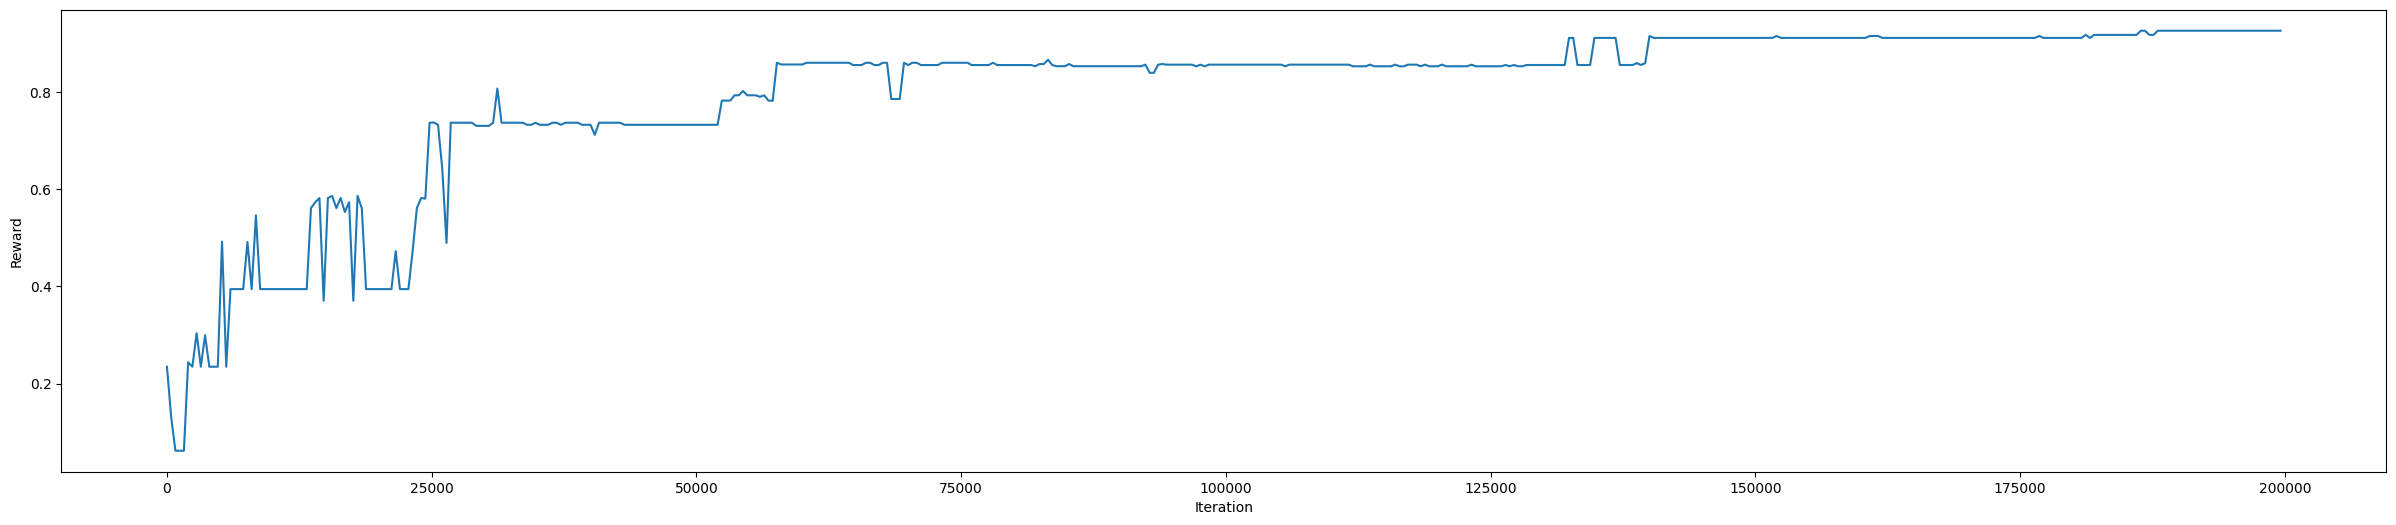

In [ ]:
#read output from last cell (which was manually saved) and plot reward evolution

#out_data = pd.read_csv('drive/My Drive/AI Fantasy NFL/rl_results', header=None)
#out_data = pd.read_csv('https://docs.google.com/spreadsheets/d/1hve2klEQdr4cYmk9bgfz1zUQrYK7E29syGfU-cP4c7k/export?format=csv', header=None)
out_data = pd.read_csv('drive/MyDrive/AI Fantasy NFL/train_logs.txt', header=None, sep='%')
i = 0
iteration = []
rewards=[]
players=[]

while i<out_data.shape[0]-1:
    iteration.append(int(out_data.iloc[i][0][10:]))
    rewards.append(float(out_data.iloc[i+1][0][8:]))
    players.append(out_data.iloc[i+2][0][9:])
    i=i+3

pivot_data = pd.DataFrame({'iteration':iteration, 'rewards':rewards, 'players':players})


plt.figure(figsize=(30, 6))
plt.plot(pivot_data.iteration, pivot_data.rewards)
plt.ylabel('Reward')
plt.xlabel('Iteration')


# Testing logs
1) A2C with 5000 iterations - the model learn something (at somewhere between 1k and 2k iterations), because it clearly reduce the amount of valleys. But it does not stabilize on the top. Also, model predictions always yield the same action on 3 steps (we always select only QBs or only WRs). Is this an issue or a effect of no position limitation?
2) Max 1 player per position - I had to reduce the amount of info going into observation for the model to properly learn. Still, we converge to a local minima, which can be clearly seen by the peak around 4k. Then, with a smaller learning rate, the model learn the pattern! But after 6k iterations, performance is degraded. Oh well
3) Adding 1 opponent selecting after us. There is a great tendency to select 2 QBs. Can we solve this somehow?
4) Yes! The main component of our reward is now how you fill your team. This made the model to very quickly converge, after less than 2k iterations. It's a little weird that it skips WR (the position which scores the second most points), but we can live with that for now.
5) Now the agent will select second. It converges! And now we have QB, RB and WR.
6) Now lets try drafting a full team of 6, one of each position. The model bounces from 2 states, but at last settles at 5k reward. The issue is that this convergence is comprised of 1RB, 1TE, 1QB, 1K, 2WR - we are missing defense. Maybe because even the best defense sucks.
7) We made it work! Two crucial changes - reduce the impact of filling positions, and increasing the number of iterations. The model takes around 60k iterations to converge with the given learning rate - and achieves a reward of 3,5k.
8) Now we will try with 9 opponents. All posistions were filled. But the selection of a kicker second is really weird. Even so, the model manages to achieve the third best team (1405 points vs. 1494 and 1411). By simply selecting a WR second and the kicker last, the final points would be 12 points greater. But our dummy opponent's result would be the same, 1405, even though a K would be selected last
9) We will apply normalization to the reward - and its outstanding the difference it made. All positions were correctly selected, a RB was selected second and a K last, and we achieved convergence in less than 20k iterations. The score, however, remained at 1405. Maybe the difference here is to small to make a difference?
10) Now we will try to select a rooster with multiple players from same positons (RBs and WRs). The model converges just under 40k iterations and chooses the correct number of positions. But it greatly underperforms the rule based system.
11) Now we can converge better, lets try and reduce the impact of position selection. And boy, we did it! After around 60k iterations, the RL achieved a whooping 1907 points - the best player, and with 40 points to spare to the second place! And 40 points better than the rule based AI in the same position.
12) Last basic functionality test! We implemented the FLEX position (which can be a WR, RB or TE) and will see how it will impact the results. Well, the model is goin to the right direction, but havent converged yet.
13) Lets reduce opponents to decrease time and check if we can achieve the desired goal with more iterations. Well, after 70k iterations the model converged, but it performed poorly, over 600 points less than the opponent.
14) We successfully eliminated the "fill team" reward support, and the result was not worse, but also not better.
15) Wait! There is a bug on our fake player! It is not selecting defense and kicker - and our model is... selecting 2 defenses?
16) More bugs! Now we were not counting the points of the flex player. After correction, we fared better than our opponents!
17) Ok, now we tried setting our AI at a different position - and boy oh boy, it learned our pattern.
18) Now we will add a third player mode - ADP. And it was the best result, we achieved 2078 vs. 1992 of the regular AI. But this is due to our success condition being the number of points.
19) The last test - let's try the code against me (and we will use it in my fantasy league later on this year). We will place the AI in 7th, because thats supposedly the worst position

In [ ]:
model = A2C.load("drive/MyDrive/AI Fantasy NFL/rl_fantasy")
vec_env = fantasy_draft(starting_board=df, team_max = [1,2,2,1,1,1,1], opponents = 9, position = 7, team_size = 9, horizon = 1, opponents_policy='adp')
n_steps = 9

# Comparing results with artificial opponents
obs = vec_env.reset()[0]
for step in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        #print(f"Step {step + 1}")
        #print(obs)
        #print("Action: ", action)
        #action = np.array([0])
        obs, reward, terminated, truncated, info = vec_env.step(int(action))
        #print("obs=", obs, "reward=", reward, "done=", done)
        #vec_env.render()
        if terminated:
            # Note that the VecEnv resets automatically
            # when a done signal is encountered
            #print("Goal reached!", "reward=", reward)
            #print('Iteration', iteration)
            print('Points=',vec_env.points)
            vec_env.render()
            #print('Opp:', vec_env.opponents[0].names)
            break
for opp in vec_env.opponents:
  print(opp.points, opp.names)

Points= 2065.69
Players: ['Tyreek Hill', 'Justin Jefferson', 'Patrick Mahomes', 'Kyle Pitts', 'Amari Cooper', 'Nyheim Hines', 'Miles Sanders', 'Justin Tucker', 'BAL']
2003.96 ['Jonathan Taylor', 'Josh Allen', 'Keenan Allen', 'Michael Pittman', 'David Montgomery', 'Damien Harris', 'Dalton Schultz', 'Ryan Succop', 'DAL']
1987.54 ['Austin Ekeler', 'James Robinson', "D'Andre Swift", 'DJ Moore', 'Justin Herbert', 'Courtland Sutton', 'Noah Fant', 'ARI', 'Matt Gay']
1958.7599999999998 ['Najee Harris', 'DK Metcalf', 'Darrell Henderson', 'Cordarrelle Patterson', 'Tyler Lockett', 'Joe Burrow', 'Darren Waller', 'SF', 'Daniel Carlson']
2038.23 ['Aaron Jones', 'Travis Kelce', 'CeeDee Lamb', 'Saquon Barkley', 'Javonte Williams', 'Chris Godwin', 'Ryan Tannehill', 'Nick Folk', 'GB']
1950.6799999999998 ['Cooper Kupp', 'Nick Chubb', 'Terry McLaurin', 'Marvin Jones', 'James Conner', 'Aaron Rodgers', 'Tyler Higbee', 'LAR', 'Harrison Butker']
2034.31 ['Davante Adams', 'Leonard Fournette', 'Mark Andrews', '

In [9]:
# Draft with only our rule based algorithms - how would it fare?

#first with default policy
print('Best Policy')
test_board = df.copy()
fakes = []
i = 0
for i in range(10):
  fakes.append(fantasy_player(max_pos=[1,2,2,1,1,1,1]))
rounds = 9
i=0
while i < rounds:
  if i % 2 == 1:
    for player in reversed(fakes):
      test_board = player.select_player(test_board)
    if i<rounds-1:
      for player in fakes:
        test_board = player.select_player(test_board)
  else: #if we selected an odd number of players, the draft direction is forward at first and then backwards
    for player in fakes:
      test_board = player.select_player(test_board)
    if i<rounds-1:
      for player in reversed(fakes):
        test_board = player.select_player(test_board)
  i = i+2


for player in fakes:
  print (round(player.points), player.names)

#then with normal policy
print('---------------------------------------------------------------------------------')
print('Normal Policy')
test_board = df.copy()
fakes = []
i = 0
for i in range(10):
  fakes.append(fantasy_player(max_pos=[1,2,2,1,1,1,1], policy='adp'))
rounds = 9
i=0
while i < rounds:
  if i % 2 == 1:
    for player in reversed(fakes):
      test_board = player.select_player(test_board)
    if i<rounds-1:
      for player in fakes:
        test_board = player.select_player(test_board)
  else: #if we selected an odd number of players, the draft direction is forward at first and then backwards
    for player in fakes:
      test_board = player.select_player(test_board)
    if i<rounds-1:
      for player in reversed(fakes):
        test_board = player.select_player(test_board)
  i = i+2


for player in fakes:
  print (round(player.points), player.names)

Best Policy
2069 ['Josh Allen', 'Aaron Jones', 'Ezekiel Elliott', 'Antonio Gibson', 'Jakobi Meyers', 'Tee Higgins', 'Mike Gesicki', 'Greg Zuerlein', 'TB']
2071 ['Patrick Mahomes', 'Najee Harris', 'Joe Mixon', 'DeVonta Smith', 'Chris Godwin', 'Jaylen Waddle', 'Dalton Schultz', 'NE', 'Brandon McManus']
2063 ['Justin Herbert', 'Travis Kelce', 'DK Metcalf', 'Amari Cooper', 'Leonard Fournette', 'A.J. Brown', 'Saquon Barkley', 'Matt Prater', 'BUF']
2014 ['Matthew Stafford', 'Austin Ekeler', 'Keenan Allen', 'Mike Williams', 'Courtland Sutton', 'Marvin Jones', 'Noah Fant', 'Harrison Butker', 'LAR']
1998 ['Dak Prescott', 'Justin Jefferson', 'CeeDee Lamb', 'Tyler Lockett', 'Nick Chubb', 'Josh Jacobs', 'Darren Waller', 'Daniel Carlson', 'SF']
2022 ['Aaron Rodgers', 'Jonathan Taylor', 'Terry McLaurin', 'Mark Andrews', 'Brandin Cooks', 'Brandon Aiyuk', 'Cordarrelle Patterson', 'Matt Gay', 'ARI']
1993 ['Joe Burrow', 'Stefon Diggs', 'Alvin Kamara', 'Michael Pittman', 'Marquise Brown', 'Myles Gaskin',

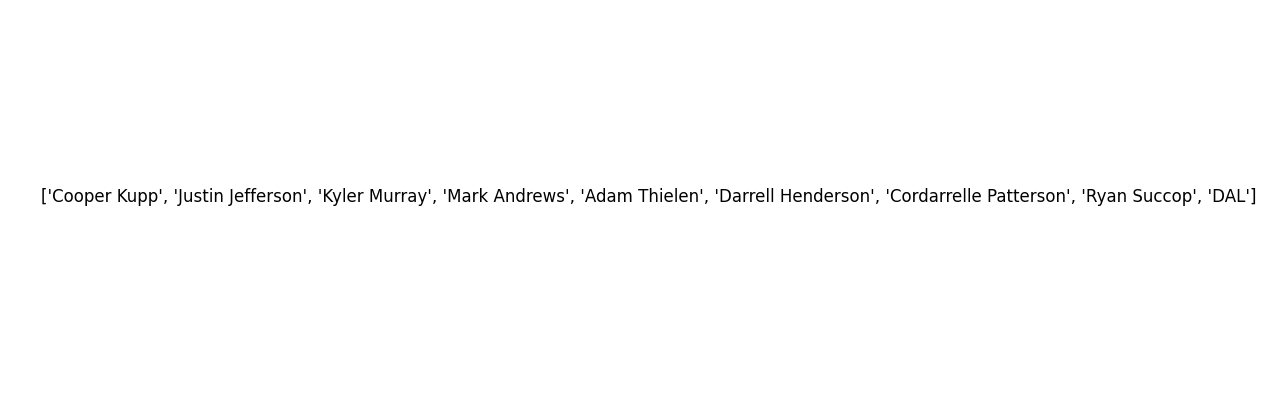

In [ ]:
#creating the training animation

fig, ax = plt.subplots(figsize=(16, 5))

ax.text(0.5,0.5,pivot_data.iloc[0,2], fontsize='large')
ax.set_xlim(0,20)
plt.axis('off')

def update(frame):
    # for each frame, update the data
    ax.cla()
    ax.text(0.5,0.5,pivot_data.iloc[frame,2], fontsize='large')
    ax.set_xlim(0,20)
    plt.axis('off')

frames = pivot_data.shape[0]-1
ani = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=40)
ani.save(filename="drive/MyDrive/AI Fantasy NFL/training_animation.mkv", writer="ffmpeg", bitrate=5000)
plt.show()

In [ ]:
pivot_data.shape[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


500